In [1]:
### Import required libraries

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics 
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os

In [2]:
### Make sure that 'ggplot' style is used for all plots
plt.style.use('ggplot')
# plt.style.available ### To view all other available styles

In [3]:
### Set Working Directory (WD)
os.chdir('/Volumes/GoogleDrive/My Drive/CEMEX/Data Translators/GitHub/rgamerosl/capstone-project')

In [4]:
### Read Final Datasets using pickle
# df = pickle.load(open('dataset/data_v2.pkl', 'rb'))
new_data = pickle.load(open('dataset/data_12f_vf.pkl', 'rb'))
data = pickle.load(open('dataset/data_42f_vf.pkl', 'rb'))

In [5]:
### Read Tree base Models
new_best_rf = pickle.load(open('dataset/PythonModels/RandomForest_19F.pkl', 'rb'))
best_rf = pickle.load(open('dataset/PythonModels/RandomForest_36F.pkl', 'rb'))
new_rfecv_RF = pickle.load(open('dataset/PythonModels/RandomForestRFE_19F.pkl', 'rb'))
rfecv_RF = pickle.load(open('dataset/PythonModels/RandomForestRFE_36F.pkl', 'rb'))

In [6]:
### Read LinearRegression Models
new_est2 = pickle.load(open('dataset/PythonModels/LinearRegression_19F.pkl', 'rb'))
est2 = pickle.load(open('dataset/PythonModels/LinearRegression_36F.pkl', 'rb'))
new_rfecv_LR = pickle.load(open('dataset/PythonModels/LinearRegressionRFE_19F.pkl', 'rb'))
rfecv_LR = pickle.load(open('dataset/PythonModels/LinearRegressionRFE_36F.pkl', 'rb'))

In [7]:
### Pairplot that takes a LOT of time

# sns.pairplot(new_data, palette='husl', corner=True, diag_kind='kde', kind='reg', markers='.', 
#                  plot_kws={'line_kws':{'color':'red', 'alpha':0.5}}, height=1.5)
# plt.savefig(f'figures/paitplots.png')

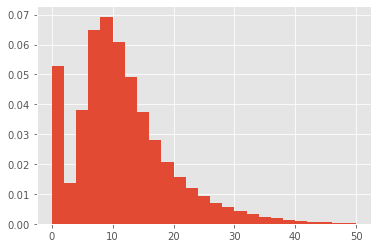

In [8]:
plt.hist(data['Speed'], density=True, bins=25)
plt.show()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417346 entries, 0 to 417345
Data columns (total 43 columns):
 #   Column                                                                              Non-Null Count   Dtype  
---  ------                                                                              --------------   -----  
 0   TurnOn                                                                              417346 non-null  int64  
 1   Idle_time                                                                           417346 non-null  float64
 2   Speed                                                                               417346 non-null  float64
 3   liters_per_hour                                                                     417346 non-null  float64
 4   Volume                                                                              417346 non-null  float64
 5   Acceleration  High level                                                            41

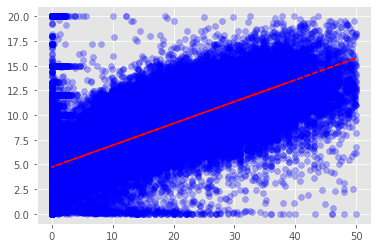

In [10]:
y = data['liters_per_hour']
x = data['Speed']

plt.scatter(x, y, alpha=0.3, color='b')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [11]:
best10cols = new_data.columns[0:10].values.tolist()
best10cols.append('liters_per_hour')
best10cols

['Speed',
 'Idle_time',
 'Volume',
 '2014',
 'TurnOn',
 'Foton Daimler',
 'International',
 'ISG11 350 - High engine torque in low rpm (before the green zone)',
 'CEM - Embrague presionado por más de 30 seg cuando el vehículo está detenido',
 'CEM- Freno presionado por encima de 10 seg y velocidad arriba de30 km/h',
 'liters_per_hour']

# Select the best 10 features and rerun both models: RandomForest and LinearRegression

## Select variables, Train/Test Split and Standarised numeric variables

In [12]:
mini_data = new_data[best10cols]
mini_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417346 entries, 0 to 417345
Data columns (total 11 columns):
 #   Column                                                                        Non-Null Count   Dtype  
---  ------                                                                        --------------   -----  
 0   Speed                                                                         417346 non-null  float64
 1   Idle_time                                                                     417346 non-null  float64
 2   Volume                                                                        417346 non-null  float64
 3   2014                                                                          417346 non-null  float64
 4   TurnOn                                                                        417346 non-null  int64  
 5   Foton Daimler                                                                 417346 non-null  float64
 6   International       

In [13]:
mini_data_train, mini_data_test = train_test_split(mini_data, test_size=0.25, random_state=42, shuffle=True)

In [14]:
num_col = mini_data.columns[[0,1,2,4,7,8,9,10]]
print(num_col)

Index(['Speed', 'Idle_time', 'Volume', 'TurnOn',
       'ISG11 350 - High engine torque in low rpm (before the green zone)',
       'CEM - Embrague presionado por más de 30 seg cuando el vehículo está detenido',
       'CEM- Freno presionado por encima de 10 seg y velocidad arriba de30 km/h',
       'liters_per_hour'],
      dtype='object')


In [15]:
### Standarize numerical variables in Train Set
scaler = StandardScaler()
mini_data_train_scale = mini_data_train.copy(deep=True)
mini_data_train_scale[num_col] = scaler.fit_transform(mini_data_train[num_col].to_numpy()) 
display(mini_data_train_scale.head(10))

,Speed,Idle_time,Volume,2014,TurnOn,Foton Daimler,International,ISG11 350 - High engine torque in low rpm (before the green zone),CEM - Embrague presionado por más de 30 seg cuando el vehículo está detenido,CEM- Freno presionado por encima de 10 seg y velocidad arriba de30 km/h,liters_per_hour
353994,-1.371689,-1.654521,-1.443800,0.0,2.337229,0.0,1.0,-0.282732,-0.283592,-0.282549,-1.596521
387557,0.566357,-0.108414,-0.426594,0.0,-0.235695,0.0,1.0,-0.282732,-0.283592,-0.282549,-0.038930
373033,0.122248,1.916859,2.182759,0.0,-1.200542,0.0,0.0,0.075424,-0.283592,-0.282549,-0.345360
410562,0.679612,-0.798412,-0.205463,0.0,-0.557311,1.0,0.0,0.075424,-0.283592,-0.282549,1.076552
127007,-0.562367,0.268530,0.413706,0.0,1.372382,0.0,1.0,-0.282732,0.078583,-0.282549,-0.515455
126900,-0.291320,-0.466191,-0.868858,0.0,-0.557311,0.0,0.0,-0.282732,0.984022,-0.282549,-0.528103
103608,1.094453,-0.881467,-0.780405,0.0,0.729151,0.0,0.0,0.075424,-0.283592,-0.282549,1.031025
372852,-0.470746,1.124638,0.236800,0.0,-1.200542,0.0,0.0,-0.282732,-0.283592,-0.282549,-0.633131
358561,-0.907220,0.549640,-0.249689,0.0,-0.878926,0.0,0.0,-0.282732,-0.283592,-0.282549,-0.701885
206157,-0.841049,2.568523,2.271211,0.0,-1.200542,0.0,0.0,-0.282732,-0.283592,-0.282549,-0.555659


In [16]:
### Standarize numerical variables in Test Set
scaler = StandardScaler()
mini_data_test_scale = mini_data_test.copy(deep=True)
mini_data_test_scale[num_col] = scaler.fit_transform(mini_data_test[num_col].to_numpy()) 
display(mini_data_test_scale.head(10))

,Speed,Idle_time,Volume,2014,TurnOn,Foton Daimler,International,ISG11 350 - High engine torque in low rpm (before the green zone),CEM - Embrague presionado por más de 30 seg cuando el vehículo está detenido,CEM- Freno presionado por encima de 10 seg y velocidad arriba de30 km/h,liters_per_hour
178424,0.242466,-0.744253,0.469344,0.0,0.093141,0.0,0.0,1.185504,-0.281994,-0.282691,1.296621
362137,1.598083,-0.468382,-0.820004,0.0,0.093141,0.0,0.0,1.736887,-0.281994,-0.282691,0.530587
115209,1.353690,-0.801993,-0.464322,0.0,-0.555530,0.0,0.0,-0.284853,-0.281994,-0.282691,-3.003957
262604,0.850903,0.493958,0.958407,0.0,-0.879865,0.0,0.0,-0.284853,-0.281994,-0.282691,0.169931
333958,-0.262867,0.891725,0.513804,0.0,0.417476,0.0,0.0,3.023449,-0.281994,-0.282691,0.297585
207469,0.102450,0.590192,0.424883,0.0,0.741812,0.0,0.0,-0.284853,-0.281994,-0.282691,0.352467
303587,0.194097,-0.089862,-0.153100,0.0,2.363489,0.0,1.0,3.391038,-0.281994,-0.282691,0.271162
69290,-1.477194,-1.674515,-1.442447,0.0,0.417476,1.0,0.0,-0.284853,-0.281994,-0.282691,-1.133056
330112,1.484797,-0.455551,-0.686623,0.0,1.066147,0.0,1.0,0.450325,-0.281994,-0.282691,0.527338
92383,-1.477194,0.910972,1.091787,0.0,-0.231194,0.0,1.0,-0.284853,-0.281994,3.161906,0.225939


In [17]:
mini_X_train = mini_data_train_scale.loc[:, mini_data_train_scale.columns != 'liters_per_hour'].values
mini_y_train = mini_data_train_scale['liters_per_hour'].values

mini_X_test = mini_data_test_scale.loc[:, mini_data_test_scale.columns != 'liters_per_hour'].values
mini_y_test = mini_data_test_scale['liters_per_hour'].values

## RandomForest Model

In [18]:
### Adjusting Best model to answer the following questions

mini_best_rf = RandomForestRegressor(n_estimators=80, n_jobs=-1, random_state=1, max_features='sqrt',
                                min_samples_leaf=2, min_samples_split=2, max_depth=None, bootstrap=False)
mini_best_rf.fit(mini_X_train, mini_y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=80, n_jobs=-1, random_state=1)

In [19]:
mini_best_rf_y_train_pred = mini_best_rf.predict(mini_X_train)
mini_best_rf_train_MSE_score = mean_squared_error(mini_y_train, mini_best_rf_y_train_pred)
print("MSE for the Best Random Forest in the Train data:", round(mini_best_rf_train_MSE_score,4))
mini_best_rf_train_R2_score = r2_score(mini_y_train, mini_best_rf_y_train_pred)
print("R2 for the Best Random Forest in the Train data:", round(mini_best_rf_train_R2_score,4))

mini_best_rf_y_test_pred = mini_best_rf.predict(mini_X_test)
mini_best_rf_test_MSE_score = mean_squared_error(mini_y_test, mini_best_rf_y_test_pred)
print("MSE for the Best Random Forest in the Test data:", round(mini_best_rf_test_MSE_score,4))
mini_best_rf_test_R2_score = r2_score(mini_y_test, mini_best_rf_y_test_pred)
print("R2 for the Best Random Forest in the Test data:", round(mini_best_rf_test_R2_score,4))

MSE for the Best Random Forest in the Train data: 0.0835
R2 for the Best Random Forest in the Train data: 0.9165
MSE for the Best Random Forest in the Test data: 0.324
R2 for the Best Random Forest in the Test data: 0.676


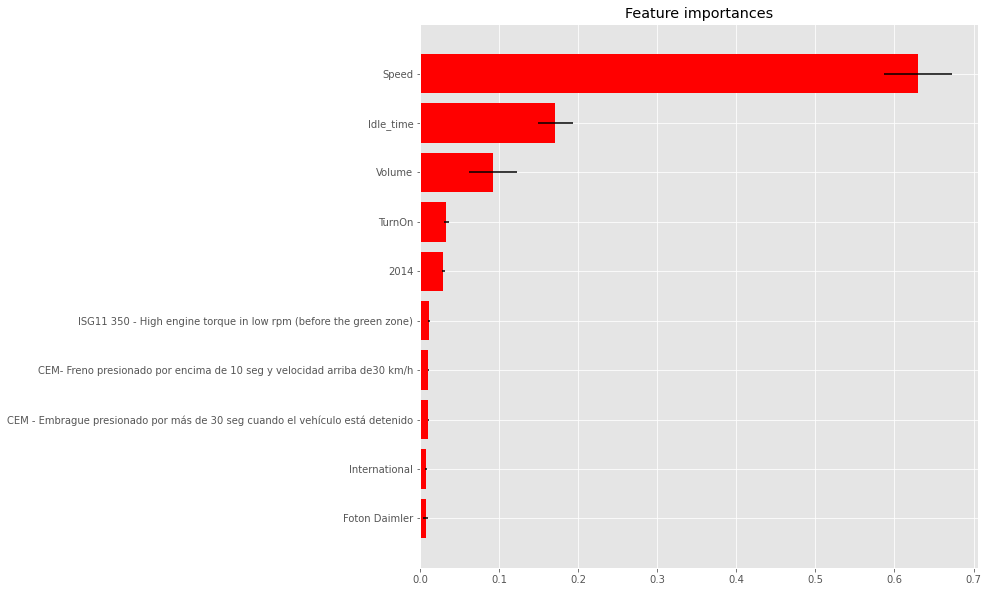

In [20]:
importances = mini_best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in mini_best_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(range(mini_X_train.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(mini_X_train.shape[1]), mini_data_train_scale.loc[:, mini_data_train_scale.columns != 'liters_per_hour'].columns[indices[::1]])
plt.ylim([-1, mini_X_train.shape[1]])
plt.savefig(f'figures/mini_feature_importances.png')
plt.show()

In [21]:
### Use RFECV with the complete data (X_train contains 36 different variables)

from sklearn.feature_selection import RFECV

min_features_to_select = 1  # Minimum number of features to consider
mini_rfecv_RF = RFECV(estimator=mini_best_rf, step=1, cv=5,
              scoring='r2',
              min_features_to_select=min_features_to_select)

mini_rfecv_RF.fit(mini_X_train, mini_y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=False, max_features='sqrt',
                                      min_samples_leaf=2, n_estimators=80,
                                      n_jobs=-1, random_state=1),
      scoring='r2')

Optimal number of features : 10


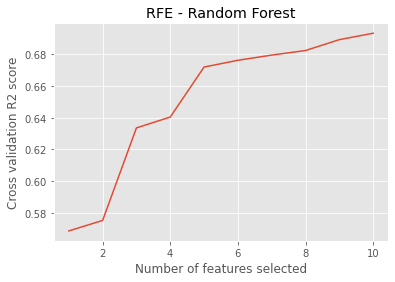

In [22]:
print("Optimal number of features : %d" % mini_rfecv_RF.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation R2 score")
plt.plot(range(min_features_to_select,
               len(mini_rfecv_RF.grid_scores_) + min_features_to_select),
         mini_rfecv_RF.grid_scores_)
plt.title("RFE - Random Forest")
plt.savefig(f'figures/mini_RFE_RF.png')
plt.show()


In [23]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mini_best_rf, mini_X_train, mini_y_train, cv=5, scoring='r2')
print(scores)
print(scores.mean())

[0.69238029 0.6928012  0.69772823 0.68781051 0.69509016]
0.6931620778661471


## LinearRegression Model

In [24]:
mini_X2_train = sm.add_constant(mini_X_train)
est = sm.OLS(mini_y_train, mini_X2_train)
mini_est = est.fit()
print(mini_est.summary())

### Doubt: How to interpret coefficients with non-standarized data?

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 4.505e+04
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:09:22   Log-Likelihood:            -3.0459e+05
No. Observations:              313009   AIC:                         6.092e+05
Df Residuals:                  312998   BIC:                         6.093e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0926      0.002    -55.699      0.0

In [54]:
mini_y_train_pred_lr = mini_est.predict(mini_X2_train)
mini_lr_train_MSE_score = mean_squared_error(mini_y_train, mini_y_train_pred_lr)
print("MSE for the Multiple Linear Regression in the Train data:", round(mini_lr_train_MSE_score,4))
mini_lr_train_R2_score = r2_score(mini_y_train, mini_y_train_pred_lr)
print("R2 for the Multiple Linear Regression in the Train data:", round(mini_lr_train_R2_score,4))

mini_X2_test = sm.add_constant(mini_X_test)
mini_y_test_pred_lr = mini_est.predict(mini_X2_test)
mini_lr_test_MSE_score = mean_squared_error(mini_y_test, mini_y_test_pred_lr)
print("MSE for the Multiple Linear Regression in the Test data:", round(mini_lr_test_MSE_score,4))
mini_lr_test_R2_score = r2_score(mini_y_test, mini_y_test_pred_lr)
print("R2 for the Multiple Linear Regression in the Test data:", round(mini_lr_test_R2_score,4))

MSE for the Multiple Linear Regression in the Train data: 0.41
R2 for the Multiple Linear Regression in the Train data: 0.59
MSE for the Multiple Linear Regression in the Test data: 0.4111
R2 for the Multiple Linear Regression in the Test data: 0.5889


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [27]:
### First VIF Analysis with all numerical variables (data)
mini_vif_y = mini_data['liters_per_hour']
mini_vif_X = mini_data.drop('liters_per_hour',axis=1)
mini_vif_model = calc_vif(mini_vif_X)
mini_vif_model.round(1)

,Features,VIF
0,Speed,2.4
1,Idle_time,7.0
2,Volume,6.5
3,2014,1.1
4,TurnOn,2.9
5,Foton Daimler,1.6
6,International,1.3
7,ISG11 350 - High engine torque in low rpm (bef...,1.1
8,CEM - Embrague presionado por más de 30 seg cu...,1.1
9,CEM- Freno presionado por encima de 10 seg y v...,1.1


In [28]:
### Use RFECV with the complete data (X_train contains 36 different variables)

from sklearn.feature_selection import RFECV

lr = LinearRegression()

min_features_to_select = 1  # Minimum number of features to consider
mini_rfecv_LR = RFECV(estimator=lr, step=1, cv=5,
              scoring='r2',
              min_features_to_select=min_features_to_select)

mini_rfecv_LR.fit(mini_X2_train, mini_y_train)

RFECV(cv=5, estimator=LinearRegression(), scoring='r2')

Optimal number of features : 10


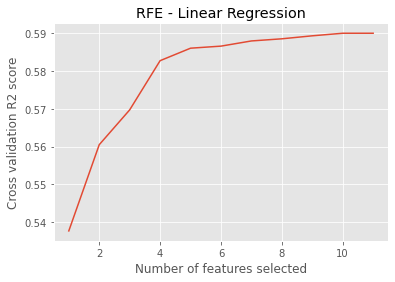

In [29]:
print("Optimal number of features : %d" % mini_rfecv_LR.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation R2 score")
plt.plot(range(min_features_to_select,
               len(mini_rfecv_LR.grid_scores_) + min_features_to_select),
         mini_rfecv_LR.grid_scores_)
plt.title("RFE - Linear Regression")
plt.savefig(f'figures/mini_RFE_LR.png')
plt.show()

In [30]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, mini_X2_train, mini_y_train, cv=5, scoring='r2')
print(scores)
print(scores.mean())

[0.59054231 0.59034135 0.59768311 0.57821509 0.59303392]
0.5899631548195463


### In both cases taking into account the next 10 features only improves the R2 score by ~5%... it seems likes is not worth it

## Pairplots

In [31]:
mini_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417346 entries, 0 to 417345
Data columns (total 11 columns):
 #   Column                                                                        Non-Null Count   Dtype  
---  ------                                                                        --------------   -----  
 0   Speed                                                                         417346 non-null  float64
 1   Idle_time                                                                     417346 non-null  float64
 2   Volume                                                                        417346 non-null  float64
 3   2014                                                                          417346 non-null  float64
 4   TurnOn                                                                        417346 non-null  int64  
 5   Foton Daimler                                                                 417346 non-null  float64
 6   International       

In [32]:
print(mini_data.columns[0:10])

Index(['Speed', 'Idle_time', 'Volume', '2014', 'TurnOn', 'Foton Daimler',
       'International',
       'ISG11 350 - High engine torque in low rpm (before the green zone)',
       'CEM - Embrague presionado por más de 30 seg cuando el vehículo está detenido',
       'CEM- Freno presionado por encima de 10 seg y velocidad arriba de30 km/h'],
      dtype='object')


In [38]:
sampling = mini_data.sample(n=80000, random_state=42)
plt.style.use("fivethirtyeight")

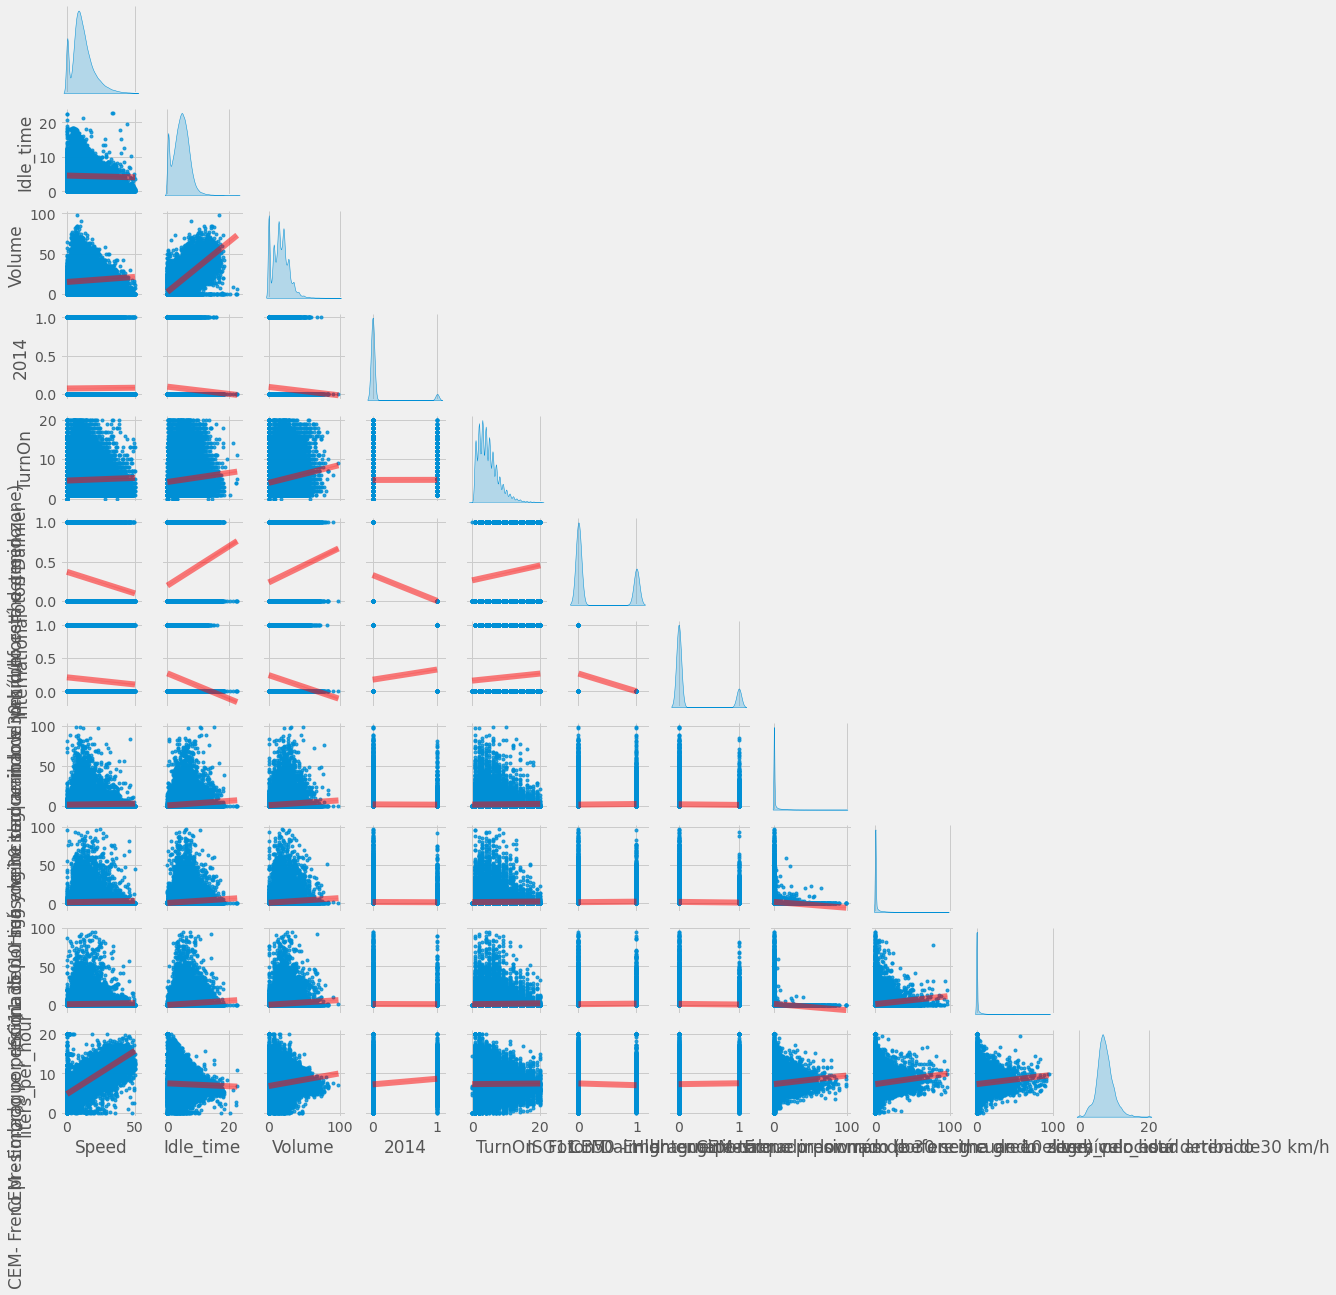

In [39]:
### Pairplot that takes a LOT of time

sns.pairplot(sampling, palette='husl', corner=True, diag_kind='kde', kind='reg', markers='.', 
                 plot_kws={'line_kws':{'color':'red', 'alpha':0.5}}, height=1.5)
plt.savefig(f'figures/pairplots.png')

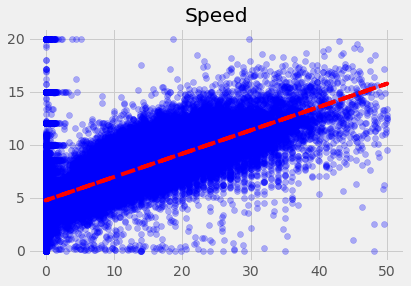

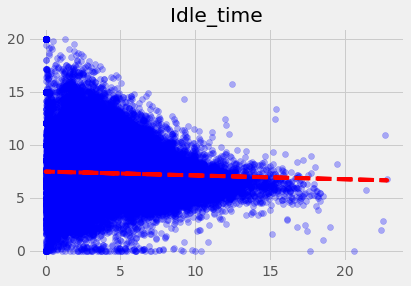

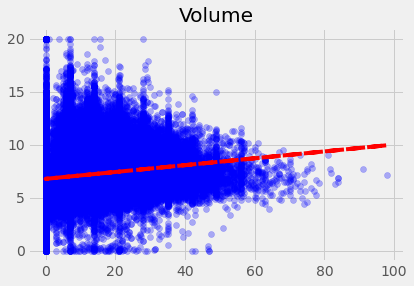

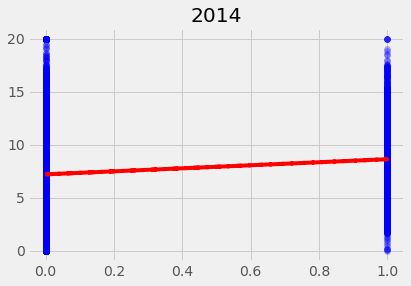

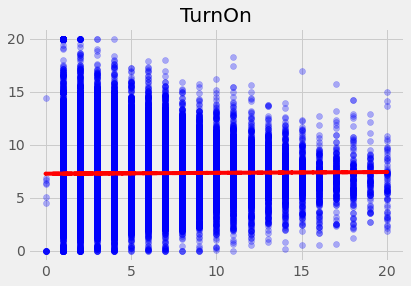

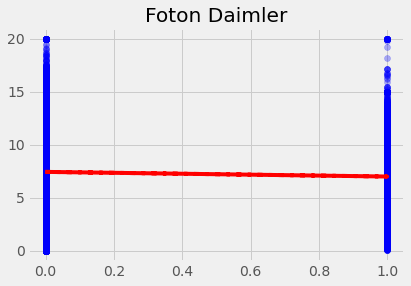

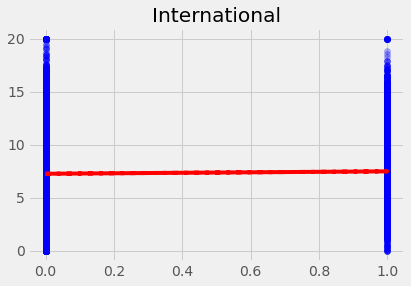

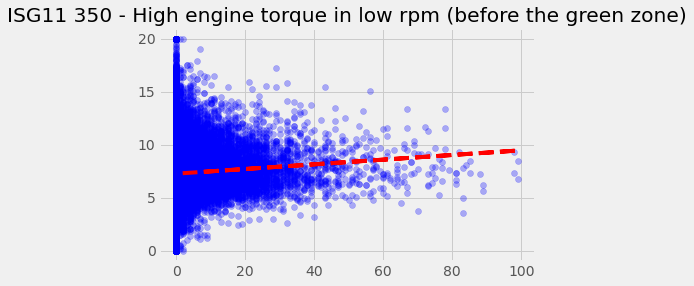

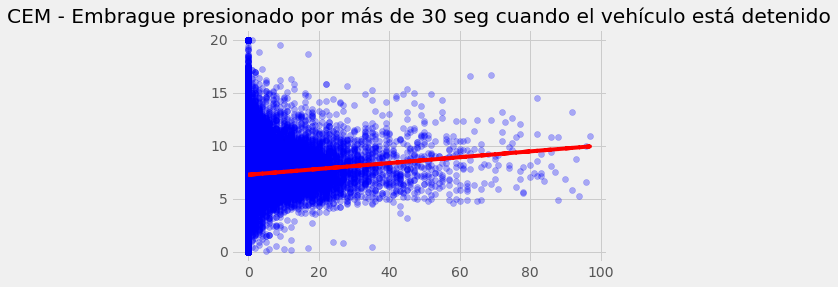

In [40]:
y = sampling['liters_per_hour']
for i in sampling.columns[0:9]:
    x = sampling[i]

    plt.scatter(x, y, alpha=0.3, color='b')
    plt.title(f'{i}')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.savefig(f'figures/{i}-feature.png', bbox_inches='tight')
    plt.show()

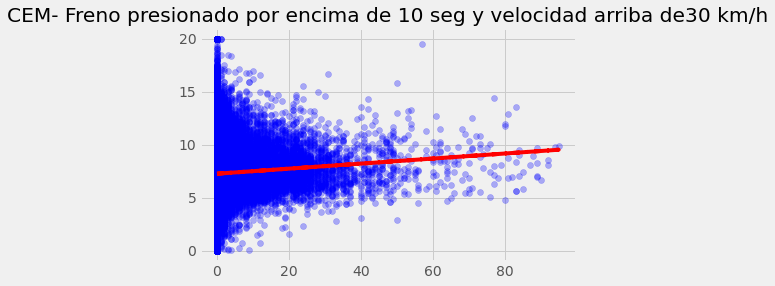

In [42]:
i = sampling.columns[9]
x = sampling[i]

plt.scatter(x, y, alpha=0.3, color='b')
plt.title(f'{i}')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.savefig(f'figures/CEM- Freno presionado por encima de 10 seg y velocidad arriba de30 kph-feature.png', bbox_inches='tight')
plt.show()

## Simple LinearRegressionusing only Speed

In [49]:
SpeedF = mini_X2_train[:,0:2]

In [50]:
est = sm.OLS(mini_y_train, SpeedF)
mini_est_S = est.fit()
print(mini_est_S.summary())

### Doubt: How to interpret coefficients with non-standarized data?

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 3.641e+05
Date:                Wed, 24 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:02:43   Log-Likelihood:            -3.2338e+05
No. Observations:              313009   AIC:                         6.468e+05
Df Residuals:                  313007   BIC:                         6.468e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.467e-17      0.001   3.68e-14      1.0

In [55]:
mini_y_train_pred_lrS = mini_est_S.predict(SpeedF)
mini_lrS_train_MSE_score = mean_squared_error(mini_y_train, mini_y_train_pred_lrS)
print("MSE for the Simple Linear Regression in the Train data:", round(mini_lrS_train_MSE_score,4))
mini_lrS_train_R2_score = r2_score(mini_y_train, mini_y_train_pred_lrS)
print("R2 for the Simple Linear Regression in the Train data:", round(mini_lrS_train_R2_score,4))

SpeedF_test = mini_X2_test[:,0:2]
mini_y_test_pred_lrS = mini_est_S.predict(SpeedF_test)
mini_lrS_test_MSE_score = mean_squared_error(mini_y_test, mini_y_test_pred_lrS)
print("MSE for the Simple Linear Regression in the Test data:", round(mini_lrS_test_MSE_score,4))
mini_lrS_test_R2_score = r2_score(mini_y_test, mini_y_test_pred_lrS)
print("R2 for the Simple Linear Regression in the Test data:", round(mini_lrS_test_R2_score,4))

MSE for the Multiple Linear Regression in the Train data: 0.4623
R2 for the Multiple Linear Regression in the Train data: 0.5377
MSE for the Multiple Linear Regression in the Test data: 0.4628
R2 for the Multiple Linear Regression in the Test data: 0.5372
